<a href="https://colab.research.google.com/github/neselidondurma/embl_tutorial/blob/main/embl_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Downloading necessary packages
!pip install torch torch_geometric matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.3 MB/s eta 0:00:00


In [225]:
# Importing (calling) the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from scipy.spatial import Delaunay
from sklearn.preprocessing import LabelEncoder
# from IPython.display import Image, display, HTML
from PIL import Image
from torch_geometric.utils import to_networkx
import networkx as nx
import random

In [226]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [227]:
def display_image(img_fpath: str, target_width: int = 900):
    """
    Display an image with a consistent width while maintaining the aspect ratio.

    Parameters:
        img_fpath (str): Path to the image file.
        target_width (int): The desired width for the image (default is 300 pixels).
    """
    img = Image.open(img_fpath)
    w, h = img.size

    # Calculate the new height to maintain the aspect ratio
    aspect_ratio = h / w
    target_height = int(target_width * aspect_ratio)

    # Resize the image
    img = img.resize((target_width, target_height))
    display(img)


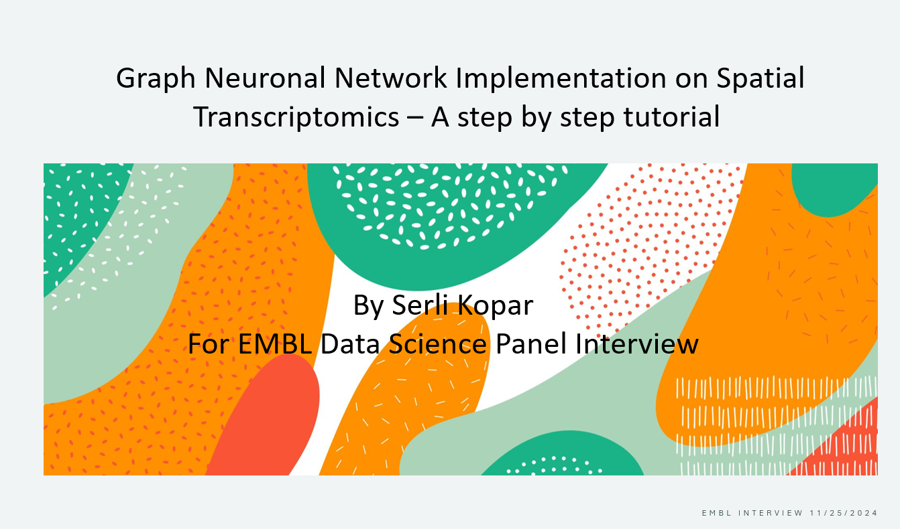

In [228]:
base_dir = '/content/drive/MyDrive/embl_data_science'
display_image(img_fpath=base_dir+'/embl_entry.png')

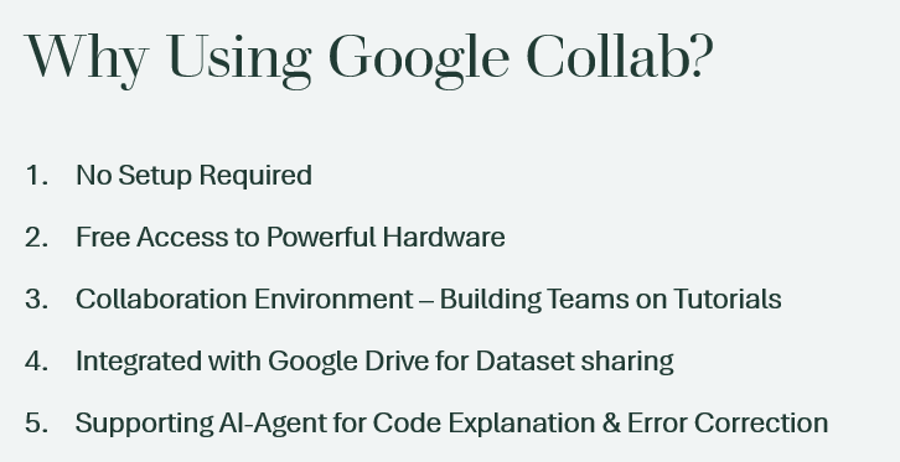

In [229]:
display_image(img_fpath=base_dir+'/collab.png')

# In this tutorial we will be working with spatial data having single cell resolution ...

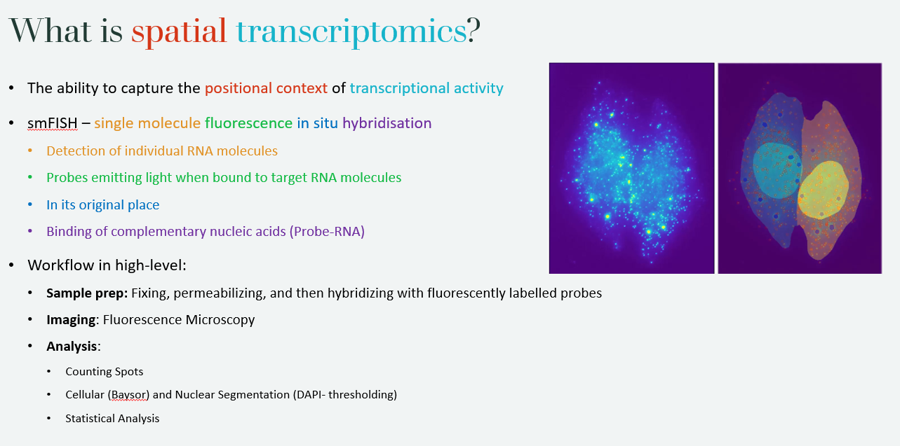

In [230]:
display_image(img_fpath=base_dir+'/spatial_data.png')

Dataset: Cell segmentation in imaging-based spatial transcriptomics
October 2021Nature Biotechnology 40(3):1-10
DOI:10.1038/s41587-021-01044-w

# ...and graph neural networks

But this is a complex topic to let's go step by step

# Graph

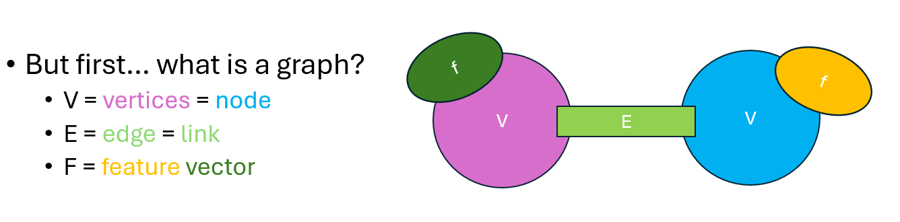

In [231]:
display_image(img_fpath=base_dir+'/graph.png')

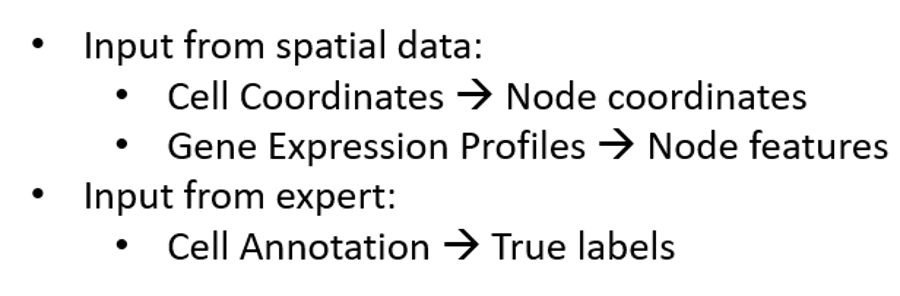

In [232]:
display_image(img_fpath=base_dir+'/graph_progress.png')

# Perceptron

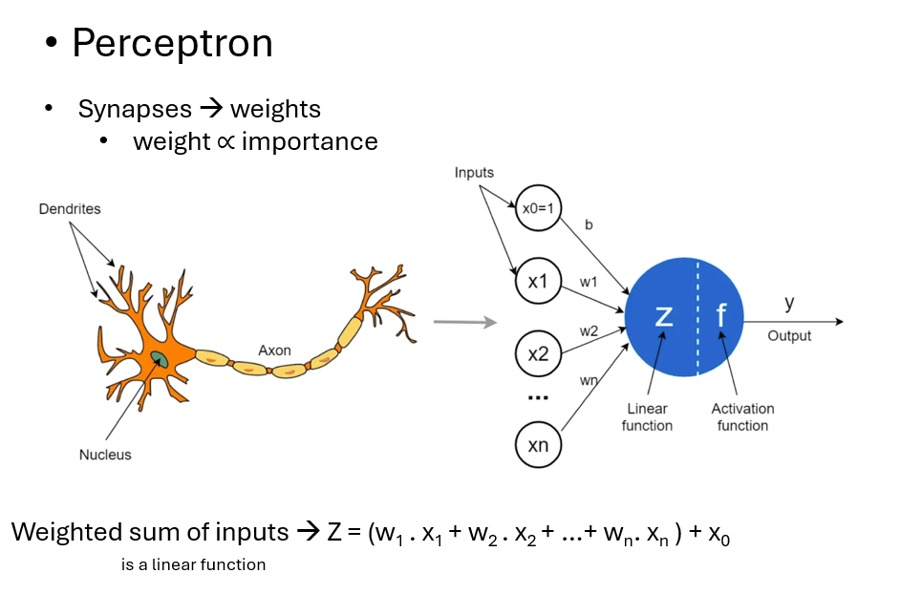

In [233]:
display_image(img_fpath=base_dir+'/perc.png')

# Multi Layer Perceptron -  Neural Network

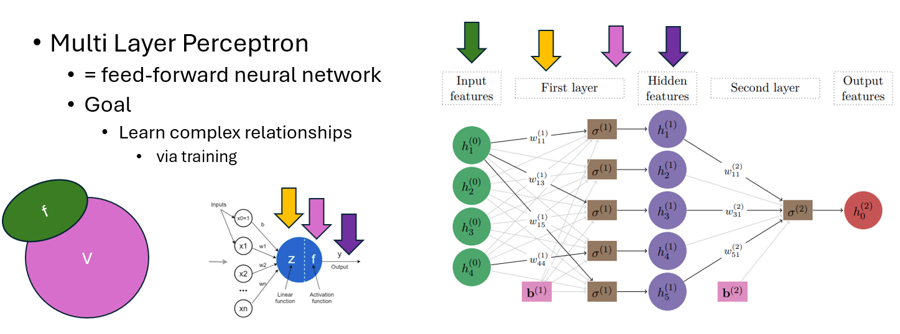

In [197]:
display_image(img_fpath=base_dir+'/mlp.png')

# Graph Neural Network

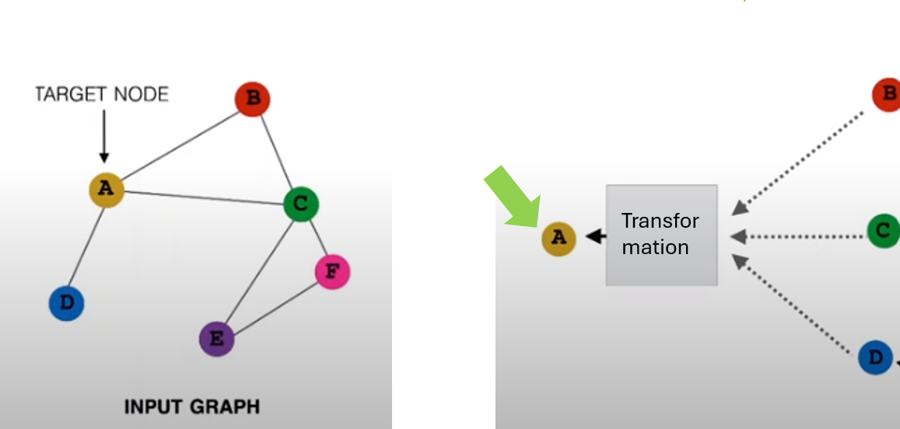

In [201]:
display_image(img_fpath=base_dir+'/input_graph.png')

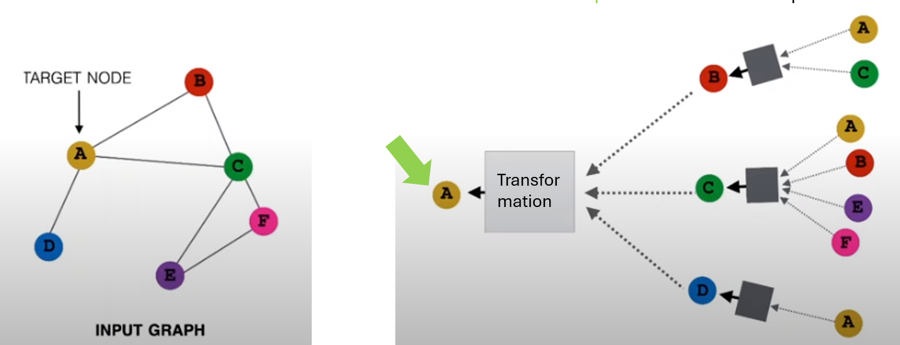

In [203]:
display_image(img_fpath=base_dir+'/second_hop.png')

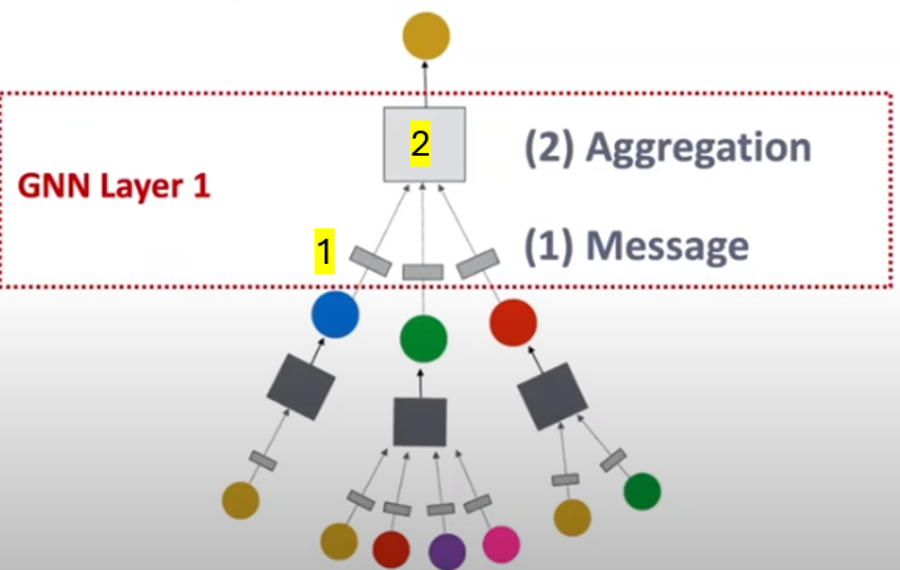

In [204]:
display_image(img_fpath=base_dir+'/graph_sum.png')

So far in GNNs we were using sum aggregation only, but here we can use sum, mean, max... = Different Types of GNNs

For example the biggest problem was that the information from node itself could be diluted more than neighbours --> Solution:GraphSAGE

Original Paper: Hamilton, William L. et al. “Inductive Representation Learning on Large Graphs.” Neural Information Processing Systems (2017).

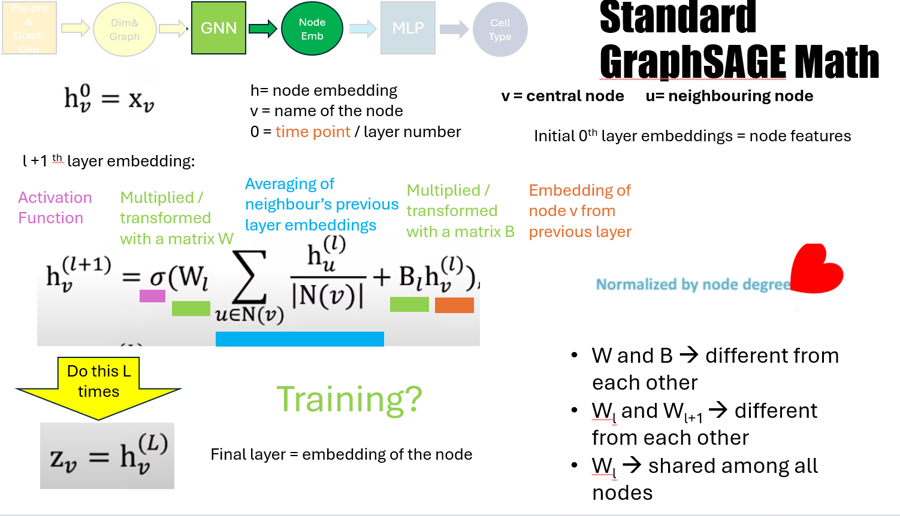

In [207]:
display_image(img_fpath=base_dir+'/sage_math.png')

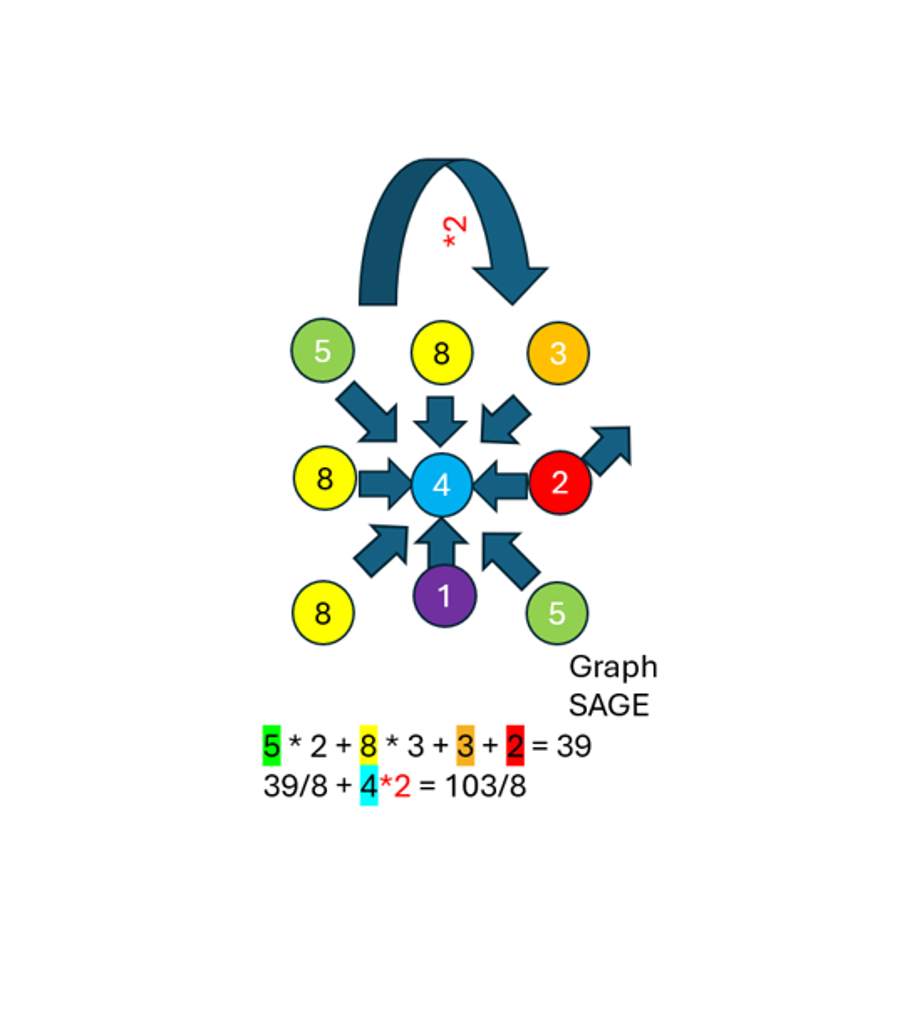

In [215]:
display_image(img_fpath=base_dir+'/sage_math_example.png')

# Enough Theory - Let's Code !!!

# Step 1: Reading and Understanding the spatial data

In [234]:
cell_gene = pd.read_parquet("/content/drive/MyDrive/embl_data_science/cell_by_gene.parquet")
cell_gene.head()

Acsl1  Acta2  Ada  Adgrd1  Adgrf5  Adra1a  Adra1b  Adra1d  Adra2a  \
cell_id                                                                      
cell1        0      0    0       0       1       0       0       0       0   
cell2        0     39    0       2       0       0       0       0       0   
cell3        0     49    0       2       0       0       0       0       0   
cell4        0    124    0       1       0       0       0       0       0   
cell5        2    100    0       0       0       0       0       0       0   

         Adra2b  ...  Tm4sf4  Tnfrsf21  Tpsb2  Trdc  Trpm5  Tspan13  Txndc5  \
cell_id          ...                                                          
cell1         0  ...       0         1      0     0      0        0       0   
cell2         0  ...       0         0      0     0      0        0       0   
cell3         0  ...       0         0      0     0      0        0       0   
cell4         1  ...       0         0      0     0      0        0       1   
cell5         0  ...       0         0      0     0      0        1       0   

         Tymp  Vcan  Vim  
cell_id                   
cell1       0     0    9  
cell2       0     0    5  
cell3       0     0    4  
cell4       0     0    2  
cell5       0     0    1  

[5 rows x 241 columns]

In [235]:
cell_coords = pd.read_parquet("/content/drive/MyDrive/embl_data_science/cell_coords.parquet")
cell_coords.head()

x          y
cell_id                        
cell1    2070.404762  19.023810
cell2    2071.304348  87.072464
cell3    2091.342857  61.800000
cell4    2150.839744  40.916667
cell5    2238.180180  29.891892

## Task 1: Reading Cluster Annotation File

Please read the cluster annotation file which will give the cell annotations --> which cell type it belongs to

In [236]:
cell_annotation = pd.read_parquet("/content/drive/MyDrive/embl_data_science/cluster_assignment.parquet")
cell_annotation.head()

cluster_id      cell_type
cell_id                           
cell1            17       Telocyte
cell2            12  Smooth Muscle
cell3            14        Stromal
cell4            12  Smooth Muscle
cell5            12  Smooth Muscle

# Summary field: What do we have so far

Please add your notes here ...

PS: If you want to write any notes for yourself, you have two options:


1) Using the **+Text** button on the middle top to create a comment field


2) Using **#** within the code cell to write your small comments explaining the functionality of the code

# Step 2: Preparing the data for graph construction

Here we are converting everything to torch tensors

In [237]:
# Convert DataFrames to NumPy arrays first
features = torch.tensor(cell_gene.values, dtype=torch.float)  # shape [num_cells, num_genes]
coordinates = torch.tensor(cell_coords.values, dtype=torch.float)  # shape [num_cells, 2]

In [238]:
cell_annotation = cell_annotation.astype(str)

In [239]:
cell_annotation

cluster_id                cell_type
cell_id                                     
cell1            17                 Telocyte
cell2            12            Smooth Muscle
cell3            14                  Stromal
cell4            12            Smooth Muscle
cell5            12            Smooth Muscle
...             ...                      ...
cell8165         11                 Pericyte
cell8166         14                  Stromal
cell8167          8          Macrophage + DC
cell8176          4  Enterocyte (Mid Villus)
cell8198         13                Stem + TA

[7416 rows x 2 columns]

In [124]:
cell_annotation["cell_type"].nunique()

19

This means we have 19 unique cell types

In [125]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(cell_annotation["cell_type"])  # Convert to 1D array and encode
labels = torch.tensor(encoded_labels, dtype=torch.long)

In [126]:
print("Unique labels:", labels.unique().tolist())

Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


#What are we doing here ??? ☹

Hence we will be training a GNN (same for any AI model) we need the data to be in a format that computer can easily understand = numbers

Because computer will not understand what a "T-Cell" is but it can work with "18"

# The new terminologies I learned here: Make your own notes! ⚓

**Pandas Dataframe:** A high-level data structure designed for working with labeled or tabular data.
DataFrames (2D) and Series (1D) support mixed data types and have row and column labels

**Numpy Array:** A low-level data structure for working with numeric or homogeneous data (single data type).
Supports multidimensional arrays (e.g., 1D, 2D, 3D arrays).

**Torch Tensor:** PyTorch tensors require data to be homogeneous (same data type, e.g., float or int).
Pandas DataFrames can hold mixed data types, which is not suitable for tensor operations.


# For advanced users only: Why using numpy is not enough? ⏰

**PyTorch Tensors:**

Can operate on both CPU and GPU, enabling GPU acceleration for faster computations using frameworks like CUDA.
Operations can be performed on GPU tensors with minimal code changes, e.g., .to('cuda').


**NumPy Arrays:**

Only operate on the CPU, so they are slower for large-scale computations or tasks requiring heavy matrix operations.

# Step 3: Generating a KNN graph

We will be using this for GNN training

In [103]:
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=538974 sha256=3f594979325be483d3c5f7924caf399ec280bfaff2290d26f2c8791adb6fa4cc
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1104576 sha256=da5aadab5de056a1631176276703614bd6686fa3040f3452525e099c042beaef
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
  Created wheel for torch-spline-conv: filename=torch_spline_conv-1.2.2-cp310-cp310-linux_x86_64.whl size=227095 sha256=79e49827733e51eff19d6ac2f

In [135]:
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def construct_knn_graph(positions, features, labels, k):
    positions_np = positions.numpy()
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(positions_np)
    distances, indices = nbrs.kneighbors(positions_np)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:  # Exclude self-loops
                edge_index.append([i, neighbor])
    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    graph = Data(x=features, y=labels, pos=positions, edge_index=edge_index)
    return graph





In [128]:
# For example we pick 5 nearest neighbours
k = 5
knn_graph = construct_knn_graph(positions=coordinates, features=features, labels=labels, k=k)
print(knn_graph)

Data(x=[7416, 241], edge_index=[2, 37080], y=[7416], pos=[7416, 2])


In [140]:
def visualize_knn_graph(graph):
    """
    Visualize the KNN graph using node positions and edges.
    :param graph: PyTorch Geometric Data object containing the graph.
    """
    # Extract node positions and edges
    positions = graph.pos.numpy()  # Node positions as a numpy array
    edge_index = graph.edge_index.numpy()  # Edges as a numpy array

    # Create a dictionary for positions
    pos_dict = {i: (positions[i][0], positions[i][1]) for i in range(len(positions))}

    # Create a NetworkX graph
    G = nx.Graph()

    # Add edges
    for edge in edge_index.T:  # Iterate over columns of edge_index
        G.add_edge(edge[0], edge[1])

    # Visualize the graph
    plt.figure(figsize=(8, 6))
    nx.draw(
        G,
        pos=pos_dict,  # Pass positions
        with_labels=True,  # Show node labels
        node_color="skyblue",  # Customize node color
        node_size=1,  # Customize node size
        font_size=0.1,  # Customize font size
        font_weight='bold'  # Bold labels
    )
    plt.title("K-Nearest Neighbors Graph")
    plt.show()




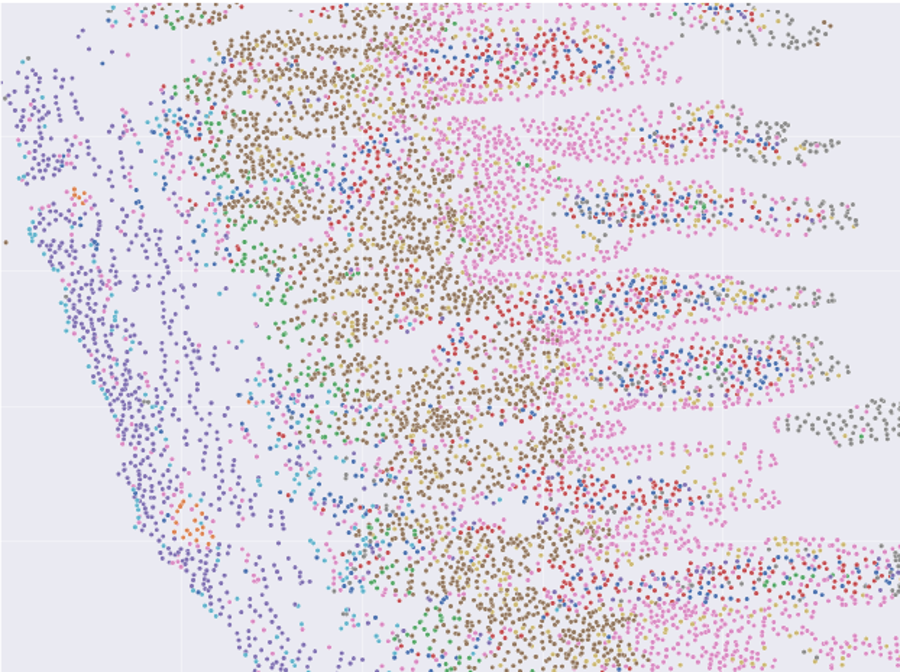

In [193]:
display_image(img_fpath=base_dir+'/mouse_int.png')

# The layout looks a little tight

So we are visualising the subgraph of 10 nodes with edges

In [152]:
def visualize_sub_knn_graph(graph):
    """
    Visualize the KNN graph using node positions and edges.
    :param graph: PyTorch Geometric Data object containing the graph.
    """
    # Extract node positions and edges
    positions = graph.pos.numpy()  # Node positions as a numpy array
    edge_index = graph.edge_index.numpy()  # Edges as a numpy array

    # Create a dictionary for positions
    pos_dict = {i: (positions[i][0], positions[i][1]) for i in range(len(positions))}

    # Create a NetworkX graph
    G = nx.Graph()

    # Add edges
    for edge in edge_index.T:  # Iterate over columns of edge_index
        G.add_edge(edge[0], edge[1])

    # Visualize the graph
    plt.figure(figsize=(8, 6))
    nx.draw(
        G,
        pos=pos_dict,  # Pass positions
        with_labels=True,  # Show node labels
        node_color="red",  # Customize node color
        node_size=200,  # Customize node size
        font_size=10,  # Customize font size
        font_weight='bold'  # Bold labels
    )
    plt.title("K-Nearest Neighbors Sub-Graph with 10 Nodes")
    plt.show()

In [153]:
num_nodes = 10
# Slice the tensors
subset_coordinates = coordinates[:num_nodes]
subset_features = features[:num_nodes]
subset_labels = labels[:num_nodes]

# Construct the KNN graph for the first 20 rows
k = 5
knn_sub_graph = construct_knn_graph(
    positions=subset_coordinates,
    features=subset_features,
    labels=subset_labels,
    k=k
)

print(knn_sub_graph)

Data(x=[10, 241], edge_index=[2, 40], y=[10], pos=[10, 2])


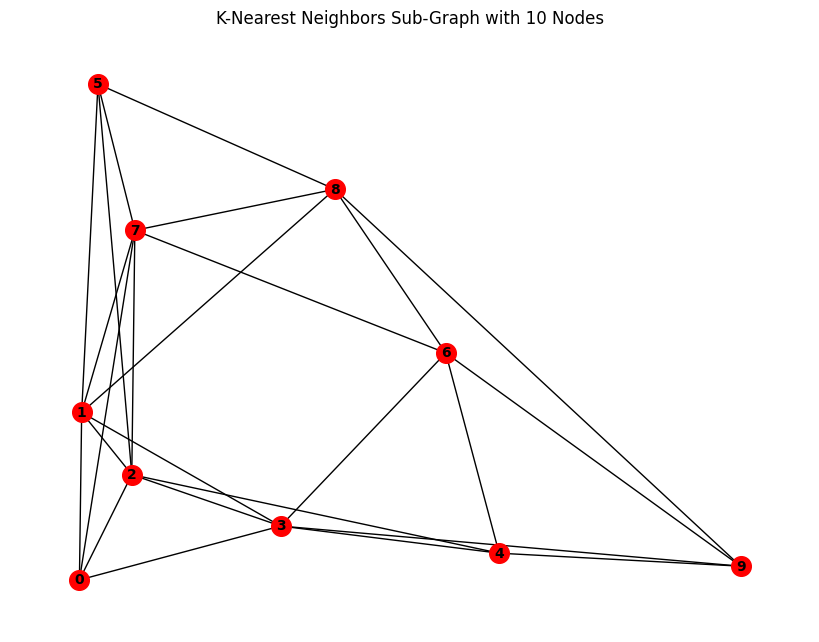

In [154]:
visualize_sub_knn_graph(knn_sub_graph)

## For experienced user: Can you try to explain why there are nodes having degree bigger than 5?

Here is a hint to help you:

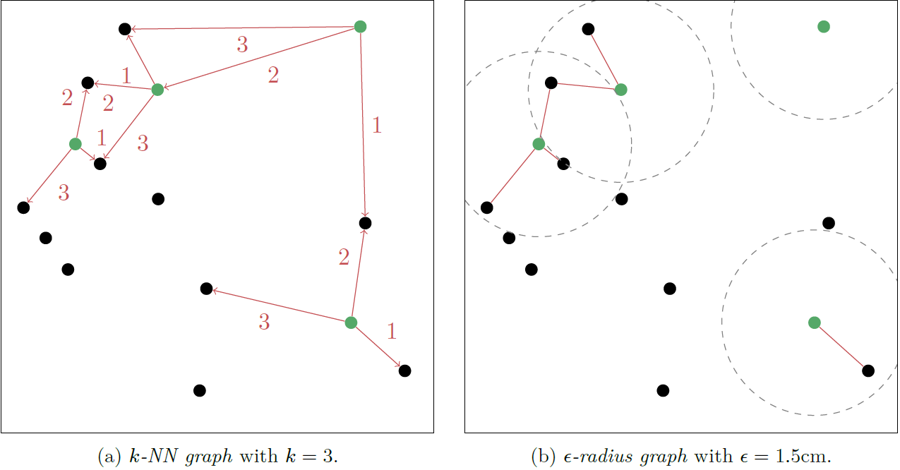

In [216]:
display_image(img_fpath=base_dir+'/knn_radius.png')

In [240]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [241]:
class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [242]:
def train_model(graph, num_epochs=10, learning_rate=0.01, log_file="training_logs.txt"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move graph data to the device
    graph = graph.to(device)

    # Define model, optimizer, and loss function
    model = GraphSAGE(input_dim=graph.x.size(1), hidden_dim=16, output_dim=graph.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.NLLLoss()

    # Open log file
    with open(log_file, "w") as log:
        log.write("Epoch\tLoss\n")  # Log headers

    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        out = model(graph.x, graph.edge_index)

        # Compute loss
        loss = loss_fn(out, graph.y)
        loss.backward()
        optimizer.step()

        # Save logs
        with open(log_file, "a") as log:
            log.write(f"{epoch}\t{loss.item():.4f}\n")

        # Print progress
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

    return model


In [243]:
trained_model = train_model(knn_graph, num_epochs=10, learning_rate=0.01, log_file="training_logs.txt")

# Check the training logs
with open("training_logs.txt", "r") as log:
    print(log.read())

Epoch 1/10, Loss: 3.8177
Epoch 2/10, Loss: 2.3726
Epoch 3/10, Loss: 1.8593
Epoch 4/10, Loss: 1.6141
Epoch 5/10, Loss: 1.4405
Epoch 6/10, Loss: 1.3021
Epoch 7/10, Loss: 1.1771
Epoch 8/10, Loss: 1.0722
Epoch 9/10, Loss: 1.0022
Epoch 10/10, Loss: 0.9289
Epoch	Loss
1	3.8177
2	2.3726
3	1.8593
4	1.6141
5	1.4405
6	1.3021
7	1.1771
8	1.0722
9	1.0022
10	0.9289



In [244]:
def visualize_training_logs(log_file="training_logs.txt"):
    # Load the log file
    logs = pd.read_csv(log_file, sep="\t")

    # Plot the loss over epochs
    plt.figure(figsize=(8, 6))
    plt.plot(logs["Epoch"], logs["Loss"], marker="o", linestyle="-")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.show()

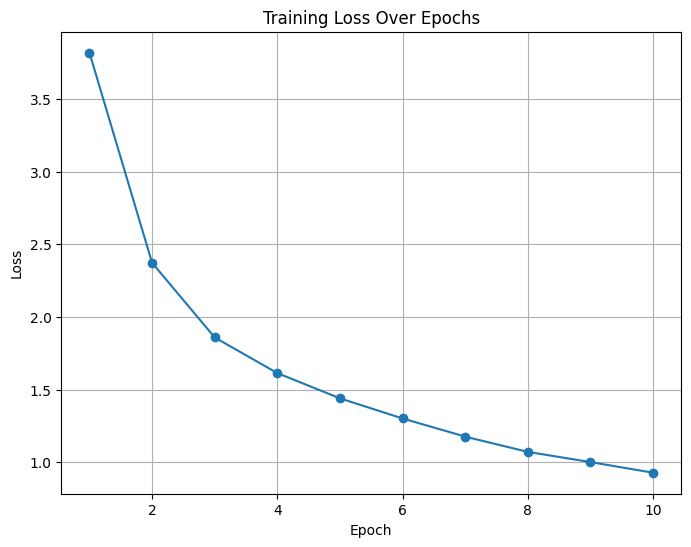

In [245]:
visualize_training_logs("training_logs.txt")

# Results

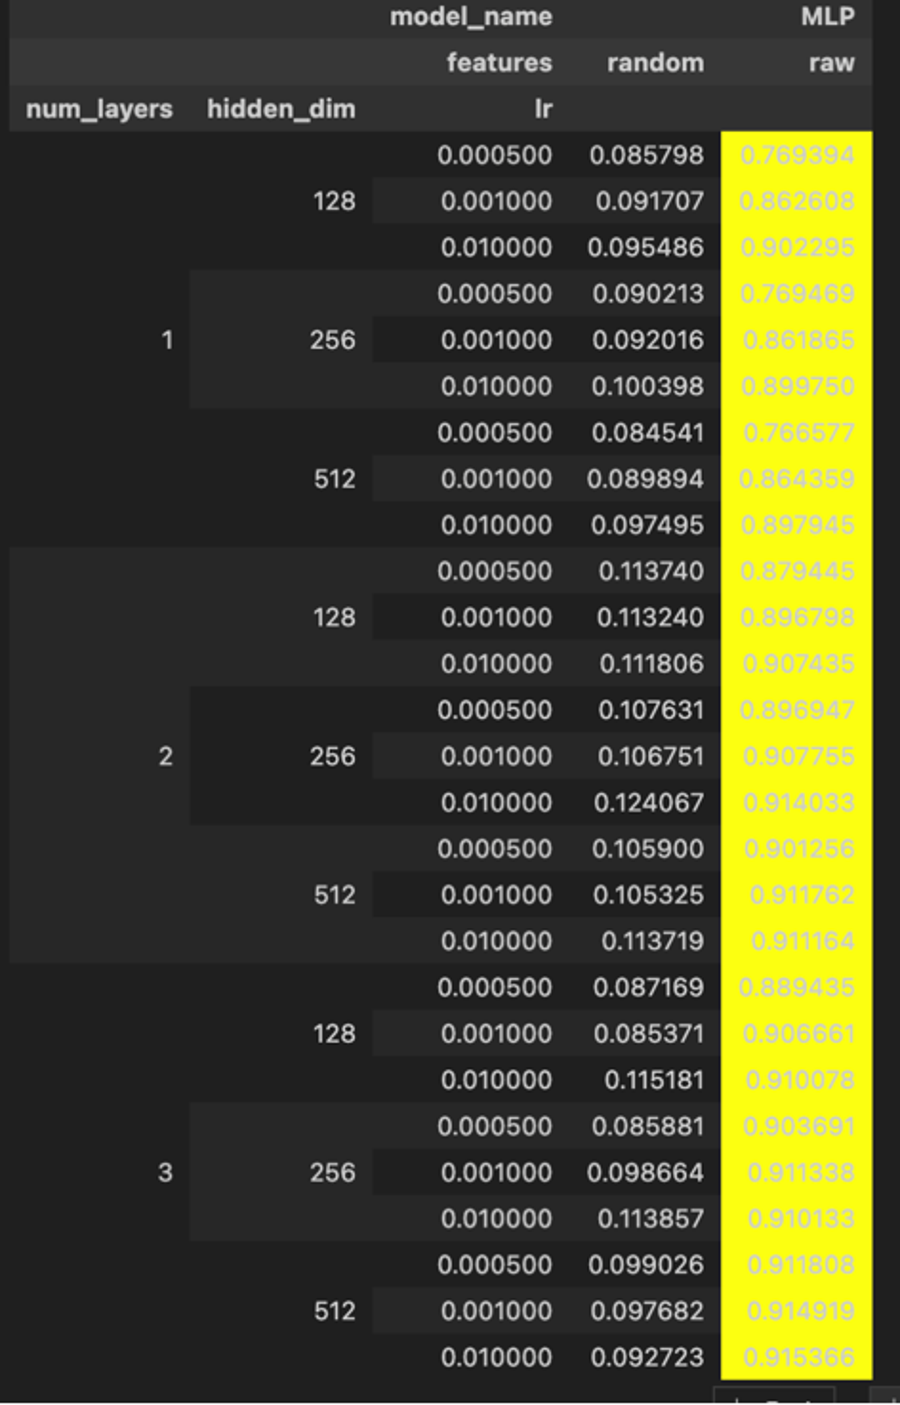

In [220]:
display_image(img_fpath=base_dir+'/mlp_res.png')

## So we decided to get information from neighbours and not the cell itself

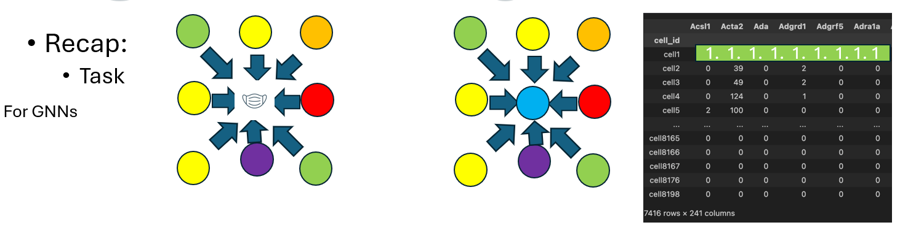

In [218]:
display_image(img_fpath=base_dir+'/gnn_mask.png')

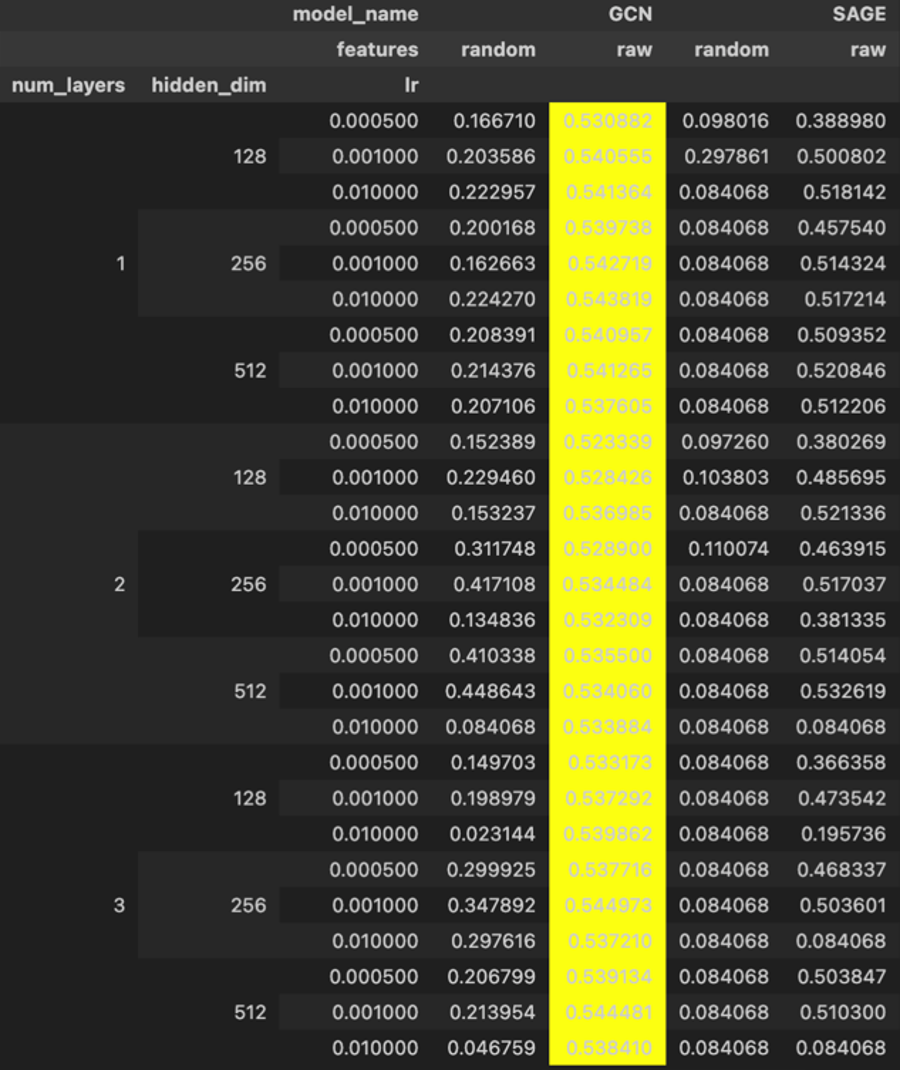

In [221]:
display_image(img_fpath=base_dir+'/gnn_baseline.png')

# Teaching with AI Experience

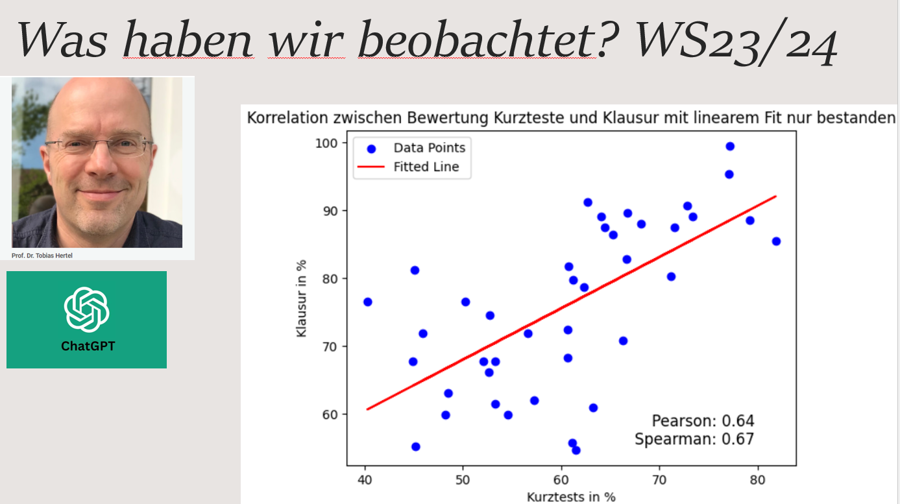

In [223]:
display_image(img_fpath=base_dir+'/chatbot_ws_23_24.png')

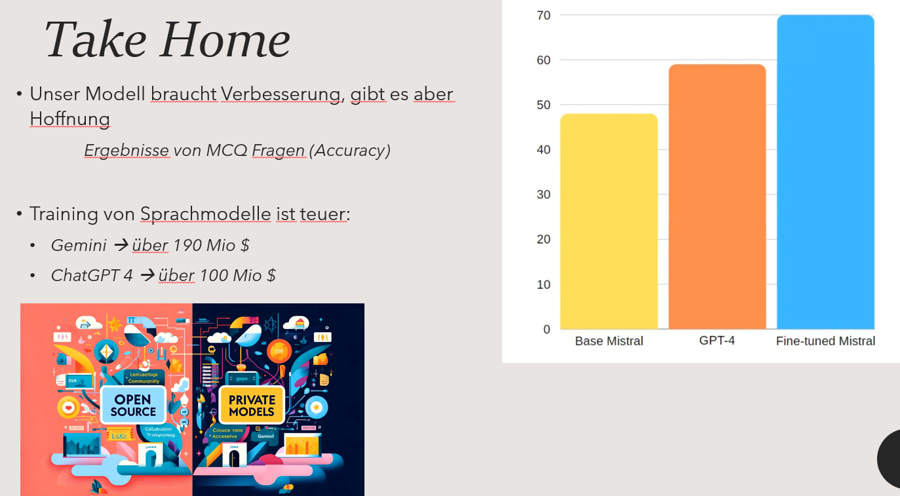

In [224]:
display_image(img_fpath=base_dir+'/mistral_results.png')